<a href="https://colab.research.google.com/github/sanaaria/Master-thesis/blob/main/KGE_NFM_%26_NFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
################################
#This script provide a demo of KGE_NFM & NFM, the runtime on one fold mainly takes 40~50 minutes.


In [2]:
#  !pip uninstall ampligraph

In [3]:
# pip install rdflib==7.0.0

In [4]:
# pip install scipy==1.10.0

In [5]:
# pip install tensorflow==1.13.1

In [6]:
# pip install tensorflow==2.13

In [7]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [8]:
# pip install torch==1.5.0 torchvision==0.6.0

ERROR: Could not find a version that satisfies the requirement torch==1.5.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2)
ERROR: No matching distribution found for torch==1.5.0


In [9]:
pip install scikit-learn==0.24.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [10]:
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [11]:
# pip install deepctr

In [12]:
pip install ampligraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.6 MB/s

In [13]:
pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: ampligraph, bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


In [14]:
import ampligraph as ampligraph

In [15]:
print(ampligraph.__version__)

2.0.1


In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import ampligraph as ampligraph
from ampligraph.datasets import load_from_csv

In [17]:
# from ampligraph.evaluation import train_test_split_no_unseen,generate_corruptions_for_fit
# # from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.datasets import load_from_csv


In [18]:
# from ampligraph.evaluation import evaluate_performance
# As of version 1.1.1, Ampligraph removed the 'evaluate_performance' function and instead introduced the 'mrr_score', 'hits_at_k', and 'mean_rank' functions to calculate metrics for evaluating model performance.
# If you are using version 2.0.1, you should be able to use the 'mrr_score', 'hits_at_k', and 'mean_rank' functions to calculate the desired metrics. Here's an example of how you can do this
from ampligraph.evaluation import mrr_score

In [19]:
from ampligraph.evaluation import mrr_score, hits_at_n_score ,mr_score

In [20]:
# from ampligraph.evaluation.common import generate_corruptions
from ampligraph.latent_features.layers.corruption_generation import CorruptionGenerationLayerTrain

In [21]:
# from ampligraph import ComplEx,TransE,DistMult

In [22]:
from ampligraph.latent_features.layers.scoring import ComplEx

In [23]:
from ampligraph.latent_features.layers.scoring import TransE

In [24]:
from ampligraph.latent_features.layers.scoring import DistMult

In [25]:
# from ampligraph.evaluation import evaluate_performance

In [26]:
# from ampligraph.utils import save_model,restore_model
from ampligraph.utils import save_model
from ampligraph.utils import restore_model

In [27]:
# import deepctr

In [28]:
from tensorflow.python.keras.models import Model

In [29]:
from tensorflow.python.keras.layers import Dense, Dropout

In [30]:
# print(deepctr.__version__)

In [31]:
from keras.layers import LSTM, Lambda, Layer, Dropout

In [32]:
# from tensorflow.python.keras.layers import LSTM, Lambda, Layer, Dropout

In [33]:
# import tf.keras.layers.LSTM

In [34]:
# NFM stands for Neural Factorization Machine, which is a type of neural network designed for recommendation systems.
# from deepctr.models import NFM

In [35]:
# from deepctr.feature_column import SparseFeat,DenseFeat,get_feature_names

In [36]:
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,Adagrad,Adamax


In [37]:
from tensorflow import keras

In [38]:
#load data
################################################################

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
#data example: yamanishi_08
dt_08 = pd.read_csv('/content/drive/MyDrive/data/yamanishi_08/dt_all_08.txt',delimiter='\t',header=None)
# the script reads a csv file using pandas' read_csv function. This function reads the file from the specified path, which in this case is
# /content/drive/MyDrive/data/yamanishi_08/dt_all_08.txt.

dt_08.columns = ['head','relation','tail']
# the columns of the DataFrame dt_08 are set using the columns attribute. The column names are 'head', 'relation', and 'tail'.

In [40]:
#kg
# ##This code is written in Python using the pandas library.
# #The goal of this code is to load two text files,
# which contain Knowledge Graph (KG) data, and concatenate them into a single pandas DataFrame.
# The KG data in these text files consists of triples (head, relation, tail), which are essentially edges in a graph.
# The 'head' is the subject, the 'relation' is the predicate, and the 'tail' is the object.

kg1 = pd.read_csv('/content/drive/MyDrive/data/yamanishi_08/kg_data/kegg_kg.txt',delimiter='\t',header=None)
# The pd.read_csv() function reads the specified file and creates a DataFrame. The delimiter='\t' argument tells pandas to use tabs as separators.
# The header=None argument tells pandas that the first row of the file does not contain column names.

kg2 = pd.read_csv('/content/drive/MyDrive/data/yamanishi_08/kg_data/yamanishi_uniprot_kg.txt',delimiter='\t',header=None)
#This code is similar to the previous one.

kg = pd.concat([kg1,kg2])
#Concatenate the two DataFrames.
#The pd.concat() function concatenates the input DataFrames into a single DataFrame.

kg.index = range(len(kg))
#Reset the index of the concatenated DataFrame.
#The index attribute of a DataFrame represents the index of the rows.
#This line of code resets the index of the concatenated DataFrame so that it starts from 0 and increments by 1.

kg.columns = ['head','relation','tail']
#Set the column names of the concatenated DataFrame.
#This line of code assigns new column names to the concatenated DataFrame.


#The resulting kg DataFrame contains the combined KG data from both text files.
# The DataFrame has three columns: 'head', 'relation', and 'tail'. The rows represent the triples (head, relation, tail) in the KG.

In [41]:
print(kg)

           head               relation        tail
0        D00183       DRUG_PATHWAY_MAP    map07014
1      hsa05200           PATHWAY_GENE    hsa:2002
2       hsa:223               GENE_EC3  ec:1.2.1._
3      map07048  PATHWAY_COMPOUND_DRUG      D00809
4      hsa04614           PATHWAY_DRUG      D01119
...         ...                    ...         ...
95667  hsa:5800          INTERACT_WITH    hsa:7010
95668  hsa:5777          INTERACT_WITH    hsa:3932
95669  hsa:5777          INTERACT_WITH    hsa:5747
95670  hsa:5777          INTERACT_WITH    hsa:6098
95671  hsa:5091          INTERACT_WITH      Q03463

[95672 rows x 3 columns]


In [42]:
kg.shape

(95672, 3)

In [43]:
kg1.shape

(59222, 3)

In [44]:
kg2.shape

(36450, 3)

In [45]:
print(59222+36450)

95672


In [46]:
##This code is a preprocessing step for the neural feature matrix (NFM) used in recommendation systems.
#It performs label encoding and min-max scaling on the categorical data in the input dataframe.
#for nfm input
# The first two lines create two LabelEncoder objects.
# These are used to convert categorical variables into a numerical format that can be understood by machine learning algorithms.
# The LabelEncoder() function is called twice to create two objects, head_le and tail_le.
head_le = LabelEncoder()
tail_le = LabelEncoder()

# The fit() method is called on both objects. This method calculates the necessary parameters to perform the encoding.
head_le.fit(dt_08['head'].values)
tail_le.fit(dt_08['tail'].values)

# The MinMaxScaler is imported from the preprocessing module of the sklearn library. This is used to scale the data.
mms = MinMaxScaler(feature_range=(0,1))


In [47]:
print(dt_08)

        head     relation       tail
0     D00002  DRUG_TARGET     hsa:10
1     D00448  DRUG_TARGET     hsa:10
2     D00037  DRUG_TARGET    hsa:100
3     D00155  DRUG_TARGET    hsa:100
4     D00021  DRUG_TARGET  hsa:10056
...      ...          ...        ...
5122  D00143  DRUG_TARGET   hsa:8856
5123  D00211  DRUG_TARGET   hsa:8856
5124  D00730  DRUG_TARGET   hsa:8856
5125  D00506  DRUG_TARGET   hsa:9970
5126  D00163  DRUG_TARGET   hsa:9971

[5127 rows x 3 columns]


In [48]:
print(head_le)

LabelEncoder()


In [49]:

###descriptors preparation

#The drug id and sequence are read from the respective CSV files and stored in a DataFrame called fp_id.
fp_id = pd.read_csv('/content/drive/MyDrive/data/yamanishi_08/791drug_struc.csv')['drug_id']

#RThe protein id, protein id sequence, and protein sequence are read from the respective CSV files and stored in a DataFrame called df_proseq.
#The columns of this DataFrame are then renamed to 'pro_id', 'pro_ids', and 'seq'.
df_proseq = pd.read_csv('/content/drive/MyDrive/data/yamanishi_08/989proseq.csv')
df_proseq.columns = ['pro_id','pro_ids','seq']

#The pro_id, which represents the unique identifier for each protein, is extracted from the df_proseq DataFrame.
pro_id = df_proseq['pro_id']

# The drug features are read from the morganfp.txt file using the np.loadtxt() function and stored in the drug_feats variable.
drug_feats = np.loadtxt('/content/drive/MyDrive/data/yamanishi_08/morganfp.txt',delimiter=',')

#The protein features are read from the pro_ctd.txt file using the np.loadtxt() function and stored in the pro_feats variable.
pro_feats = np.loadtxt('/content/drive/MyDrive/data/yamanishi_08/pro_ctd.txt',delimiter=',')

# The protein features are then scaled using the MinMaxScaler. The scaled features are stored in the pro_feats_scaled variable.
pro_feats_scaled = mms.fit_transform(pro_feats)

#Next, PCA is applied to reduce the dimensionality of the scaled protein features to 100 components. The reduced features are stored in the pro_feats_scaled2 variable.
pro_feats_scaled2 = PCA(n_components=100).fit_transform(pro_feats_scaled)

#The reduced protein features are then scaled again using the MinMaxScaler. The scaled features are stored in the pro_feats_scaled3 variable.
pro_feats_scaled3 = mms.fit_transform(pro_feats_scaled2)

#Finally, the fp_df and prodes_df DataFrames are created by concatenating the drug id and drug features (represented by drug_feats),
#and the protein id and protein features (represented by pro_feats_scaled3), respectively.
fp_df = pd.concat([fp_id,pd.DataFrame(drug_feats)],axis=1)
prodes_df = pd.concat([pro_id,pd.DataFrame(pro_feats_scaled3)],axis=1)


In [102]:
# print(fp_id)
# fp_df.head(10)

In [51]:
# prodes_df.head(10)

,pro_id,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,hsa:10,0.492745,0.378991,0.247887,0.365602,0.362159,0.338746,0.646155,0.436877,0.531654,...,0.492017,0.601584,0.417904,0.425675,0.592996,0.408399,0.457260,0.438626,0.688754,0.000000
1,hsa:100,0.506456,0.429743,0.369211,0.339106,0.604534,0.454493,0.571485,0.464988,0.494835,...,0.395271,0.474973,0.330398,0.359915,0.512509,0.558766,0.474174,0.550298,0.511907,0.520552
2,hsa:10056,0.630732,0.457383,0.328126,0.297027,0.400041,0.434246,0.522574,0.401249,0.533447,...,0.483456,0.362159,0.366754,0.325713,0.553785,0.477632,0.513323,0.505420,0.376806,0.693254
3,hsa:1017,0.591641,0.493375,0.197547,0.456034,0.346906,0.571221,0.594414,0.437832,0.486730,...,0.322506,0.596818,0.263635,0.468745,0.837764,0.400961,0.402539,0.493352,0.507665,0.752739
4,hsa:1018,0.635572,0.494294,0.218801,0.486494,0.423561,0.509730,0.520542,0.425348,0.493557,...,0.427998,0.815488,0.057152,0.106609,0.984301,0.452878,0.901570,0.635765,0.347485,0.166801
5,hsa:10188,0.580887,0.683118,0.509173,0.292143,0.555119,0.520207,0.446041,0.451692,0.547668,...,0.458968,0.440202,0.493066,0.230446,0.435839,0.414468,0.437404,0.463290,0.442572,0.495039
6,hsa:1019,0.414452,0.366858,0.438011,0.372351,0.577573,0.395744,0.370834,0.543521,0.367073,...,0.283762,0.617893,0.503509,0.442142,0.431474,0.378769,0.417106,0.562390,0.363959,0.630620
7,hsa:1020,0.728091,0.486550,0.334128,0.549522,0.344012,0.388372,0.512808,0.476311,0.347143,...,0.435133,0.424743,0.472877,0.751366,0.563651,0.460353,0.532301,0.557606,0.549010,0.679088
8,hsa:1021,0.611166,0.495431,0.362506,0.422822,0.478290,0.401122,0.526785,0.411057,0.517399,...,0.281713,0.443160,0.252996,0.536164,0.629548,0.426170,0.458679,0.583234,0.308439,0.562610
9,hsa:1022,0.590316,0.470978,0.397042,0.398146,0.410757,0.422528,0.416759,0.312970,0.468853,...,0.335355,0.790922,0.587026,0.412889,0.312246,0.631539,0.437243,0.456430,0.577971,0.550854


In [52]:
# from matplotlib import pyplot as plt
# _df_11[3].plot(kind='line', figsize=(8, 4), title=3)
# plt.gca().spines[['top', 'right']].set_visible(False)

In [53]:
# from matplotlib import pyplot as plt
# _df_3[1].plot(kind='hist', bins=20, title=1)
# plt.gca().spines[['top', 'right',]].set_visible(False)

In [54]:

#Function
################################################################

# If you want to test other scenarios, just change the data path.
# But it should be noted that the hypermeters in nfm need to be adjusted.
# Typiclly, the l2_reg_dnn & l2_reg_linear = 1e-5 is enough in the warm start.
# For the cold start, the l2_reg_dnn & l2_reg_linear need to be larger, like 1e-3.

data_path = '/content/drive/MyDrive/data/yamanishi_08/data_folds/warm_start_1_10'


######This function is designed to work with 10-fold cross-validation, as it assumes there are 10 different folds for the training and testing sets.
# Therefore, the input i represents the current fold. The function loads the training and testing data for this fold and returns them.
# In addition, the function merges the positive train examples and the knowledge graph into a single dataframe,
# which is used for creating the embeddings. This is why the data dataframe includes only the head, relation, and tail attributes, without the label attribute.
def load_data(i):
    # Read the train_fold csv file. The label is included.
    train = pd.read_csv(data_path+'/train_fold_'+str(i+1)+'.csv')[['head','relation','tail','label']]

    # Select only the positive examples (label == 1) from the train set.
    train_pos = train[train['label']==1]

    # Read the test_fold csv file. The label is included.
    test = pd.read_csv(data_path+'/test_fold_'+str(i+1)+'.csv')[['head','relation','tail','label']]

    # Merge the positive train examples and the knowledge graph into a single dataframe.
    data = pd.concat([train_pos,kg])[['head','relation','tail']]


    # Return the train, train_pos, test, and data dataframes.
    return train,train_pos,test,data



In [55]:
# train,train_pos,test,data=load_data(0)

In [56]:
# test

,head,relation,tail,label
0,D00002,DRUG_TARGET,hsa:10,1.0
1,D00107,DRUG_TARGET,hsa:1033,1.0
2,D01977,DRUG_TARGET,hsa:10461,1.0
3,D03218,DRUG_TARGET,hsa:10461,1.0
4,D04023,DRUG_TARGET,hsa:10461,1.0
...,...,...,...,...
5532,D00187,DRUG_TARGET,hsa:3758,0.0
5533,D00187,DRUG_TARGET,hsa:6338,0.0
5534,D00187,DRUG_TARGET,hsa:2877,0.0
5535,D00187,DRUG_TARGET,hsa:7155,0.0


In [57]:
# columns = ['head','relation','tail']

In [58]:
# test[columns]

,head,relation,tail
0,D00002,DRUG_TARGET,hsa:10
1,D00107,DRUG_TARGET,hsa:1033
2,D01977,DRUG_TARGET,hsa:10461
3,D03218,DRUG_TARGET,hsa:10461
4,D04023,DRUG_TARGET,hsa:10461
...,...,...,...
5532,D00187,DRUG_TARGET,hsa:3758
5533,D00187,DRUG_TARGET,hsa:6338
5534,D00187,DRUG_TARGET,hsa:2877
5535,D00187,DRUG_TARGET,hsa:7155


In [59]:
# test['label'].values

array([1., 1., 1., ..., 0., 0., 0.])

In [60]:
# data.head(10)

,head,relation,tail
0,D00448,DRUG_TARGET,hsa:10
1,D00037,DRUG_TARGET,hsa:100
2,D00155,DRUG_TARGET,hsa:100
3,D00021,DRUG_TARGET,hsa:10056
4,D02880,DRUG_TARGET,hsa:1017
5,D02880,DRUG_TARGET,hsa:1018
6,D01441,DRUG_TARGET,hsa:10188
7,D02880,DRUG_TARGET,hsa:1019
8,D02880,DRUG_TARGET,hsa:1020
9,D02880,DRUG_TARGET,hsa:1021


In [61]:
# kg.head(10)

,head,relation,tail
0,D00183,DRUG_PATHWAY_MAP,map07014
1,hsa05200,PATHWAY_GENE,hsa:2002
2,hsa:223,GENE_EC3,ec:1.2.1._
3,map07048,PATHWAY_COMPOUND_DRUG,D00809
4,hsa04614,PATHWAY_DRUG,D01119
5,D01965,DRUG_ATC_C5,ATC:G04CA04
6,D00633,DRUG_GROUP,DG01467
7,D02566,DRUG_GROUP,DG01729
8,hsa04960,PATHWAY_DRUG,D05640
9,map07032,PATHWAY_COMPOUND_DRUG,D00494


In [62]:
# train.head(10)

,head,relation,tail,label
0,D00448,DRUG_TARGET,hsa:10,1.0
1,D00037,DRUG_TARGET,hsa:100,1.0
2,D00155,DRUG_TARGET,hsa:100,1.0
3,D00021,DRUG_TARGET,hsa:10056,1.0
4,D02880,DRUG_TARGET,hsa:1017,1.0
5,D02880,DRUG_TARGET,hsa:1018,1.0
6,D01441,DRUG_TARGET,hsa:10188,1.0
7,D02880,DRUG_TARGET,hsa:1019,1.0
8,D02880,DRUG_TARGET,hsa:1020,1.0
9,D02880,DRUG_TARGET,hsa:1021,1.0


In [63]:
# test.head(10)

,head,relation,tail,label
0,D00002,DRUG_TARGET,hsa:10,1.0
1,D00107,DRUG_TARGET,hsa:1033,1.0
2,D01977,DRUG_TARGET,hsa:10461,1.0
3,D03218,DRUG_TARGET,hsa:10461,1.0
4,D04023,DRUG_TARGET,hsa:10461,1.0
5,D02655,DRUG_TARGET,hsa:10846,1.0
6,D00542,DRUG_TARGET,hsa:10858,1.0
7,D00184,DRUG_TARGET,hsa:11221,1.0
8,D00538,DRUG_TARGET,hsa:11238,1.0
9,D00652,DRUG_TARGET,hsa:11238,1.0


In [64]:
# from matplotlib import pyplot as plt
# import seaborn as sns
# _df_0.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)

In [65]:


####This Python function, roc_auc, computes the area under the ROC curve (AUC-ROC) for a given binary classification problem.
#It takes two parameters: y (ground truth) and pred (predicted probabilities). The function returns the AUC-ROC score.

#This line defines the function roc_auc that takes two parameters: y and pred.
def roc_auc(y,pred):

  # This line calls the roc_curve function from the metrics module (part of the Scikit-Learn library) with y and pred as parameters.
  #The roc_curve function calculates the ROC curve for the given binary classification problem, returning false positive rate (FPR), true positive rate (TPR), and thresholds.
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)

    #roc_auc = metrics.auc(fpr, tpr): This line calls the auc function from the metrics module with fpr and tpr as parameters.
    #The auc function calculates the area under the ROC curve, which is the AUC-ROC score.
    roc_auc = metrics.auc(fpr, tpr)

    #return roc_auc: This line returns the computed AUC-ROC score.
    return roc_auc



In [66]:


###This Python function, named pr_auc, takes two parameters: y and pred. The purpose of this function is to calculate the area under the Precision-Recall curve (PR-AUC).
#the function assumes that the input arrays y and pred have the same length, as they represent the ground truth and predicted labels for a binary classification problem.
#The function will raise a ValueError if the lengths of the two input arrays do not match.
def pr_auc(y, pred):

    #The first line inside the function defines the variable precision, recall, and thresholds. It calculates these values using the precision_recall_curve function from the metrics module.
    precision, recall, thresholds = metrics.precision_recall_curve(y, pred)

    #The second line of the function calculates the PR-AUC score using the auc function from the metrics module. It takes the recall values and the precision values as input parameters.
    pr_auc = metrics.auc(recall, precision)

    #Finally, the function returns the PR-AUC score as output.The output of the function is a float number, representing the PR-AUC score.
    return pr_auc




In [67]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
# from ampligraph.latent_features import EmbeddingModel

In [68]:

###get_scaled_embeddings that takes a pre-trained knowledge graph embedding model and three sets of triples as input parameters.
# It outputs the scaled embeddings for the subjects and objects of the training and testing triples.
#In summary, this function first obtains the embeddings for the subject and object entities of the triples.
#Then, it concatenates these embeddings and applies normalization and dimensionality reduction techniques (MinMaxScaler and PCA)
#to obtain scaled embeddings that can be used for various downstream tasks.

#Defines the function and specifies the input parameters.
def get_scaled_embeddings(model,train_triples,test_triples,get_scaled,n_components):

    # For each triple, the function extracts the subject (head) entities and gets their embeddings from the pre-trained model. It does this for both the training and testing triples.
    # [train_sub_embeddings,test_sub_embeddings] = [model.get_embeddings(x['head'].values, embedding_type='entity') for x in [train_triples,test_triples]]
    [train_sub_embeddings,test_sub_embeddings]=[model.get_embeddings(x['head'].values, embedding_type='e')  for x in [train_triples,test_triples]]

    #Similarly, it extracts the object (tail) entities and gets their embeddings from the pre-trained model. Again, it does this for both the training and testing triples.
    [train_obj_embeddings,test_obj_embeddings] = [model.get_embeddings(x['tail'].values, embedding_type='e') for x in [train_triples,test_triples]]

    #The function concatenates the subject and object embeddings for each triple in the training set.
    train_feats = np.concatenate([train_sub_embeddings,train_obj_embeddings],axis=1)

    #The function also concatenates the subject and object embeddings for each triple in the testing set.
    test_feats = np.concatenate([test_sub_embeddings,test_obj_embeddings],axis=1)

    #The function applies the MinMaxScaler (mms) to the concatenated training features to obtain a set of normalized dense features.
    train_dense_features = mms.fit_transform(train_feats)

    #The function also applies the MinMaxScaler to the concatenated testing features to obtain a set of normalized dense features.
    test_dense_features = mms.transform(test_feats)

    #If the parameter get_scaled is True, the function proceeds to apply Principal Component Analysis (PCA) to the normalized dense features.
    if get_scaled:

        #The function creates a PCA instance with the specified number of components (n_components).
        pca = PCA(n_components=n_components)

        #The function applies PCA to the normalized training dense features.
        scaled_train_dense_features = pca.fit_transform(train_dense_features)

        #The function also applies PCA to the normalized testing dense features.
        scaled_pca_test_dense_features = pca.transform(test_dense_features)

    #If the parameter get_scaled is False, the function skips the PCA step and directly assigns the normalized dense features to the output variables.
    else:

        #Assigns the normalized training dense features to the output variable.
        scaled_train_dense_features = train_dense_features

        #Assigns the normalized testing dense features to the output variable.
        scaled_pca_test_dense_features = test_dense_features

    #Returns the scaled embeddings for the subjects and objects of the training and testing triples.
    return scaled_train_dense_features,scaled_pca_test_dense_features




In [69]:
# print(re_train_all)

In [70]:

# train_triples=[['John', 'works', 'Google'], ['Mary', 'studies', 'Harvard']]

In [71]:
# test_triples =[['Bob', 'visits', 'Tokyo']]

In [72]:
# model.get_embeddings(['John', 'Mary'], embedding_type='e')

In [73]:

#In summary, the function get_features takes a dataframe data, two dataframes fp_df and prodes_df, and a boolean variable use_pro.
#It extracts drug features from fp_df and protein features from prodes_df using the head and tail columns of data.
#Then, it concatenates the features horizontally based on the value of use_pro. The resulting feature matrix is returned as the output of the function.
#This line defines a function named get_features. It takes four parameters: data, fp_df, prodes_df, and use_pro.
def get_features(data,fp_df,prodes_df,use_pro):

    #This line performs a left join of data and fp_df on the 'head' column of data and the 'drug_id' column of fp_df.
    #The left join is done because we want to keep all records from the left table (i.e., data) and the matched records from the right table (i.e., fp_df).
    #Then, the code selects the 1025 columns (from the 5th to the 1029th column) of the resulting dataframe and converts it into a numpy array using the values attribute.
    #The result is stored in the variable drug_features.
    drug_features = pd.merge(data,fp_df,how='left',left_on='head',right_on='drug_id').iloc[:,4:1029].values

    #This line performs a similar operation as the previous one, but this time it joins data and prodes_df on the 'tail' column of data and the 'pro_id' column of prodes_df.
    #Again, the code selects the 101 columns (from the 5th to the 105th column) of the resulting dataframe and converts it into a numpy array using the values attribute.
    #The result is stored in the variable pro_features.
    pro_features = pd.merge(data,prodes_df,how='left',left_on='tail',right_on='pro_id').iloc[:,4:105].values

    #This line checks the value of the variable use_pro. If it is True, it concatenates drug_features and pro_features horizontally using the np.concatenate function.
    #If use_pro is False, it directly assigns drug_features to the variable feature.
    if use_pro:
        feature = np.concatenate([drug_features,pro_features],axis=1)
    else:
        feature = drug_features

    #This line returns the final feature matrix.
    return feature


In [74]:
# train.head(3)

,head,relation,tail,label
0,D00448,DRUG_TARGET,hsa:10,1.0
1,D00037,DRUG_TARGET,hsa:100,1.0
2,D00155,DRUG_TARGET,hsa:100,1.0


In [75]:
# drug_features = pd.merge(train,fp_df,how='left',left_on='head',right_on='drug_id').iloc[:,4:1029].values

In [76]:
# fp_df.head(5)

,drug_id,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,D00448,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,D00037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,D00155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,D00021,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,D01441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# data.head(5)

,head,relation,tail
0,D00448,DRUG_TARGET,hsa:10
1,D00037,DRUG_TARGET,hsa:100
2,D00155,DRUG_TARGET,hsa:100
3,D00021,DRUG_TARGET,hsa:10056
4,D02880,DRUG_TARGET,hsa:1017


In [78]:
# drug_features = pd.merge(train,fp_df,how='left',left_on='head',right_on='drug_id')
# drug_features

,head,relation,tail,label,drug_id,0,1,2,3,4,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,D00448,DRUG_TARGET,hsa:10,1.0,D00448,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,D00037,DRUG_TARGET,hsa:100,1.0,D00037,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,D00155,DRUG_TARGET,hsa:100,1.0,D00155,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,D00021,DRUG_TARGET,hsa:10056,1.0,D00021,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,D02880,DRUG_TARGET,hsa:1017,1.0,D02880,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44846,D00316,DRUG_TARGET,hsa:10549,0.0,D00316,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44847,D00316,DRUG_TARGET,hsa:54576,0.0,D00316,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44848,D00316,DRUG_TARGET,hsa:54490,0.0,D00316,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44849,D00316,DRUG_TARGET,hsa:2260,0.0,D00316,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# columns = ['head','relation','tail']

In [80]:
# x=get_features(train[columns],fp_df,prodes_df,True)

In [81]:
# y=get_features(test[columns],fp_df,prodes_df,True)

In [82]:
#'DenseFeat("des",train_des.shape[1]),'des':train_des,' is used for nfm training
#In this code, the input to get_nfm_input is the raw relational entities and their features/descriptions.
#The output is the preprocessed input data that can be used as input for a Neural Factorization Machine (NFM) model.


##Define a function named get_nfm_input with the following parameters:
# re_train_all: a dataframe of training relational entities.
# re_test_all: a dataframe of testing relational entities.
# train_feats: the training features matrix.
# test_feats: the testing features matrix.
# train_des: the training description vectors.
# test_des: the testing description vectors.
# embedding_dim: the dimensionality of the embedding space.
# pca_components: the number of PCA components to retain.
def get_nfm_input(re_train_all,re_test_all,train_feats,test_feats,train_des,test_des,embedding_dim,pca_components):

    #The next line concatenates the train_feats and train_des matrices.
    train_all_feats = np.concatenate([train_feats,train_des],axis=1)

    #Similarly, the next line concatenates the test_feats and test_des matrices.
    test_all_feats = np.concatenate([test_feats,test_des],axis=1)

    #The next line applies MinMaxScaler to the concatenated training all features matrix.
    train_all_feats_scaled = mms.fit_transform(train_all_feats)

    #The next line applies MinMaxScaler to the concatenated testing all features matrix.
    test_all_feats_scaled = mms.transform(test_all_feats)

    #The next line creates a list of feature columns, where each feature column is
    #defined as either a sparse feature (with its own unique vocabulary size and embedding dimension) or a dense feature (with a specific number of features).
    feature_columns = [SparseFeat('head',re_train_all['head'].unique().shape[0],embedding_dim=embedding_dim),
                        SparseFeat('tail',re_train_all['tail'].unique().shape[0],embedding_dim=embedding_dim),
                        DenseFeat("feats",train_all_feats_scaled.shape[1]),
                        #DenseFeat("des",train_des.shape[1])
                        ]

    #The next line creates a dictionary for the training model input.
    train_model_input = {'head':head_le.transform(re_train_all['head'].values),
                    'tail':tail_le.transform(re_train_all['tail'].values),
                     'feats':train_all_feats_scaled,
                     #'des':train_des
                    }

    #The next line creates a dictionary for the testing model input
    test_model_input = {'head':head_le.transform(re_test_all['head'].values),
                    'tail':tail_le.transform(re_test_all['tail'].values),
                    'feats':test_all_feats_scaled,
                    # 'des':test_des
                    }

    #Finally, the function returns the feature_columns, train_model_input, and test_model_input.
    return feature_columns,train_model_input,test_model_input


In [83]:
def get_nfm_input(re_train_all, re_test_all, train_feats, test_feats, train_des, test_des, embedding_dim, pca_components):
    # Concatenate train_feats and train_des matrices
    train_all_feats = np.concatenate([train_feats, train_des], axis=1)
    test_all_feats = np.concatenate([test_feats, test_des], axis=1)


    train_all_feats_scaled = mms.fit_transform(train_all_feats)

    #The next line applies MinMaxScaler to the concatenated testing all features matrix.
    test_all_feats_scaled = mms.transform(test_all_feats)



    # Dummy values for vocabulary sizes
    head_unique_count = re_train_all['head'].nunique()
    tail_unique_count = re_train_all['tail'].nunique()

    # Number of features after concatenation
    num_feats = train_all_feats.shape[1]

    # Constructing feature_columns manually without deepctr
    feature_columns = [
        {'name': 'head', 'dimension': head_unique_count, 'embedding_dim': embedding_dim},
        {'name': 'tail', 'dimension': tail_unique_count, 'embedding_dim': embedding_dim},
        {'name': 'feats', 'dimension': num_feats}
        # Add more columns as needed
    ]

    # Rest of the function remains similar to the previous implementation
    # ...
    train_model_input = {'head':head_le.transform(re_train_all['head'].values),
                    'tail':tail_le.transform(re_train_all['tail'].values),
                     'feats':train_all_feats_scaled,
                     #'des':train_des
                    }
    # train_model_input=np.array(train_model_input)
    #The next line creates a dictionary for the testing model input
    test_model_input = {'head':head_le.transform(re_test_all['head'].values),
                    'tail':tail_le.transform(re_test_all['tail'].values),
                    'feats':test_all_feats_scaled,
                    # 'des':test_des
                    }
    # test_model_input=np.array(test_model_input)
    return feature_columns, train_model_input, test_model_input


In [84]:
# import tensorflow as tf
# from deepctr.feature_column import SparseFeat, DenseFeat, create_embedding_matrix
# from deepctr.models.nfm import NFM
# from sklearn.preprocessing import LabelEncoder

In [85]:

# #the hypermeters(l2_reg_dnn & l2_reg_linear) need to be adjusted in cold start scenarios, like 1e-3
# #The following code is used to train a neural factorization machine (NFM) model for a binary classification problem.

# #The function train_nfm takes in 8 parameters: feature_columns, train_model_input, train_label, test_model_input, y, and patience.
# #The output of this function is a tuple of 3 elements: roc_nfm, pr_nfm, and pred_y[:,0].
# def train_nfm(feature_columns,train_model_input,train_label,test_model_input,y,patience):
#    #The function initializes a neural factorization machine (NFM) model by calling the NFM class with the following parameters:
#    # feature_columns, feature_columns, task='binary', dnn_hidden_units=(128,128), l2_reg_dnn=1e-5, l2_reg_linear=1e-5.
#     # re_model = NFM(feature_columns,feature_columns,dnn_hidden_units=(128,128),
#     #                 l2_reg_linear=1e-5,l2_reg_dnn=1e-5,task='binary'
#     #                 )
#     re_model = NFM(feature_columns,feature_columns, feature_columns, 1,
#              dnn_hidden_units=(128,128), dnn_dropout=0.5, dnn_activation='relu', task='binary')
#     #The NFM model is then compiled using the Adam optimizer with a learning rate of 1e-3 and the binary cross-entropy loss function. The metrics to be tracked during training are precision.
#     re_model.compile('adam', "binary_crossentropy",
#                 metrics=[keras.metrics.Precision(name='precision'),], )

#     #The function defines an early stopping callback es using the EarlyStopping class.
#     #This callback will monitor the training loss and stop training if the loss has not decreased for a specified number of epochs (patience).
#     es = EarlyStopping(monitor='loss',patience=patience,min_delta=0.0001,mode='min',restore_best_weights=True)

#     #The function trains the NFM model by calling the fit method with the following parameters: train_model_input, train_label, batch_size=20000, epochs=2000, verbose=2, and callbacks=[es].
#     #The model is trained for a maximum of 2000 epochs or until the early stopping callback decides to stop the training.
#     history = re_model.fit(train_model_input, train_label,
#                         batch_size=20000, epochs=1,
#                         verbose=2,
#                         callbacks=[es]
#                         )

#     #After training, the function evaluates the model by predicting the labels for the test data.

#             # Create a list of numpy arrays
#     numpy_arrays = [np.array(values).reshape(-1, 1) for values in test_model_input.values()]

#     # Stack the numpy arrays vertically
#     final_numpy_array = np.hstack(numpy_arrays)



#     pred_y = model.predict(test_model_input, batch_size=256)
#     # pred_y = re_model.predict(final_numpy_array, batch_size=512)
#     print("re_model_summary")
#     #The function calculates the area under the ROC curve (AUC-ROC) for the test data using the roc_auc function.
#     #This metric measures the model's ability to distinguish between the positive and negative classes.
#     roc_nfm = roc_auc(y,pred_y[:,0])

#     #The function also calculates the area under the Precision-Recall curve (AUC-PR) for the test data using the pr_auc function.
#     #This metric measures the model's ability to provide relevant results when the actual relevance is considered.
#     pr_nfm = pr_auc(y,pred_y[:,0])
#     print(roc_nfm)
#     print(pr_nfm)

#     #Finally, the function returns the ROC-AUC score, the PR-AUC score, and the predicted labels for the test data.
#     return roc_nfm,pr_nfm,pred_y[:,0]


In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, average_precision_score


In [87]:

# def train_nfm(train_model_input, train_label, test_model_input, y,i, patience):
#     # Initialize a Sequential model
#     re_model = Sequential()

#     # Add Dense layers to simulate the NFM architecture
#     re_model.add(Dense(128, activation='relu'))
#     re_model.add(Dense(128, activation='relu'))
#     re_model.add(Dense(1, activation='sigmoid'))

#     # Compile the model
#     re_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])

#     # Define EarlyStopping callback
#     es = EarlyStopping(monitor='loss', patience=patience, min_delta=0.0001, mode='min', restore_best_weights=True)

#     # Train the model
#     history = re_model.fit(train_model_input, train_label, batch_size=20000, epochs=1, verbose=2, callbacks=[es])

#     # Predict labels for test data
#     pred_y = re_model.predict(test_model_input, batch_size=256)

#     # Calculate evaluation metrics
#     roc_nfm = roc_auc_score(y, pred_y)
#     pr_nfm = average_precision_score(y, pred_y)

#     return roc_nfm, pr_nfm, pred_y[:, 0]


In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import roc_auc_score, average_precision_score
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf

def train_conv_conv_fc(train_model_input, train_label, test_model_input, test_label, patience):
    # Extract arrays from the dictionary
    train_feats = train_model_input['feats']
    test_feats = test_model_input['feats']

    # Define input shapes based on the extracted arrays
    train_input_shape = (train_feats.shape[1], 1)  # Adjust the shape according to your data
    test_input_shape = (test_feats.shape[1], 1)    # Adjust the shape according to your data

    # Initialize a Sequential model
    model = Sequential()

    # Add Convolutional layers
    model.add(Conv1D(32, 3, activation='relu', input_shape=train_input_shape))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))

    # Flatten the output before the fully connected layers
    model.add(Flatten())

    # Add fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

   # Compile the model with specified metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # print("مدل کامپایل شد")
    # Train the model
    history = model.fit(train_feats, train_label, epochs=10, batch_size=32, verbose=2, validation_split=0.2)
    # print("مدل فیت شد")
    # Predict labels for test data
    pred_y = model.predict(test_feats, batch_size=32)

    # Calculate evaluation metrics
    roc = roc_auc_score(test_label, pred_y)
    pr = average_precision_score(test_label, pred_y)

    return roc, pr, pred_y[:, 0]

In [104]:
import tensorflow as tf

In [105]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel

In [106]:
import ampligraph.latent_features.loss_functions as lfs

In [107]:
from ampligraph.latent_features.loss_functions import get as get_loss

In [108]:
from ampligraph.latent_features.regularizers import get as get_regularizer

In [109]:
#This function is used to train a neural fused model (NFM) using the train data. The model will be trained for multiple folds and then evaluated on the test data.
#The performance metrics will be computed as Area Under the ROC Curve (AUC-ROC) and Area Under the Precision-Recall Curve (AUC-PR)
#Parameters:

# i: Integer. This parameter represents the fold number for the current iteration. It is used to separate the data into train and test folds.

# test_num_neg: Integer. This parameter represents the number of negative examples used in the test data.

# train_num_neg: Integer. This parameter represents the number of negative examples used in the train data.

# embedding_dim: Integer. This parameter represents the dimensionality of the embeddings.

# n_components: Integer. This parameter represents the number of principal components used for dimensionality reduction.

# use_pro: Boolean. This parameter represents whether to use the proline as a feature in the model.

# patience: Integer. This parameter represents the number of epochs with no improvement after which the training will be stopped
def train(i,test_num_neg,train_num_neg,embedding_dim,n_components,use_pro,patience):

    #This function loads the train and test data for the current fold.
    train,train_pos,test,data = load_data(i)

    # # This function initializes the DistMult model. DistMult is a neural network based approach to perform knowledge graph embedding.
    # model = DistMult(batches_count=10000,
    #     seed=0,
    #     epochs=50,
    #     k=400,
    #     #embedding_model_params={'corrupt_sides':'o'},
    #     optimizer='adam',
    #     optimizer_params={'lr':1e-3},
    #     loss='pairwise', #pairwise
    #     regularizer='LP',
    #     regularizer_params={'p':3, 'lambda':1e-5},
    #     verbose=True)

    # #This function trains the DistMult model on the train data. It uses early stopping to prevent overfitting.
    # model.fit(data.values, early_stopping =True,early_stopping_params=
    #             {
    #                 'x_valid': train_pos[['head','relation','tail']].values,       # validation set, here we use training set for validation
    #                 'criteria':'mrr',         # Uses mrr criteria for early stopping
    #                 'burn_in': 10,              # early stopping kicks in after 10 epochs
    #                 'check_interval':2,         # validates every 2th epoch
    #                 'stop_interval':3,           # stops if 3 successive validation checks are bad.
    #                 'x_filter': dt_08.values,          # Use filter for filtering out positives
    #                 'corrupt_side':'o'         # corrupt object (but not at once)
    #             })

      # Define the model parameters
    k = 400  # embedding dimension
    eta = 10  # number of negative samples per positive sample
    epochs = 1  # number of training epochs
    batches_count = 10000  # number of batches
    optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = get_loss('pairwise', {'margin': 0.5})
    regularizer = get_regularizer('LP', {'p': 2, 'lambda': 1e-5})

    # Create the DistMult model
    model = ScoringBasedEmbeddingModel(
          k=k,
          eta=eta,
          scoring_type="DistMult",
          # optimizer="Adam",
          # loss="PairwiseMargin",
          # regularizer="LP",
          # regularizer_weight=1e-5,
          seed=42,
      )


    model.compile(optimizer=optim, loss=loss, entity_relation_regularizer=regularizer)

     ###earlystpe alakie
    checkpoint = tf.keras.callbacks.EarlyStopping(
       monitor="val_loss",
       min_delta=0,
       patience=5,
       verbose=1,
       mode='max',
       restore_best_weights=True
)
  ###
    model.fit(data.values,
              batch_size=10000,
              epochs=10 ,                  # Number of training epochs
              # # validation_freq=20,           # Epochs between successive validation
              # validation_burn_in=10,       # Epoch to start validation
              # validation_data=train_pos[['head','relation','tail']].values,   # Validation data
              # validation_filter=dt_08.values,     # Filter positives from validation corruptions
              callbacks=[checkpoint],       # Early stopping callback (more from tf.keras.callbacks are supported)
              # verbose=True                  # Enable stdout messages
              )





    #save_model(model, model_name_path = './eg_model/dismult_400_warm_1_10.pkl')
    #model = restore_model(model_name_path='./eg_model/dismult_400_warm_1_10.pkl')
    #The columns list contains the column names that correspond to the 'head', 'relation', and 'tail' entities of the triples.
    columns = ['head','relation','tail']

    #The model.predict(test[columns]) function generates a score for each triple in the test dataset. This score represents the probability of the triple being correct.
    test_score = model.predict(test[columns])

    #The test_label variable stores the true labels for the triples in the test dataset.
    test_label = test['label'].values


    #kge performance evaluation
    roc = roc_auc(test_label,test_score)
    pr = pr_auc(test_label,test_score)
    # print(roc)
    # print(pr)


    #nfm preparation
    re_train_all = train[columns]
    re_test_all = test[columns]
    train_label = train['label']

    #This function generates the embeddings for the train and test data.
    train_dense_features,test_dense_features = get_scaled_embeddings(model,re_train_all,re_test_all,False,n_components)







    #This function generates the additional features (chemical features, proline features, etc.) for the train and test data.
    train_des = get_features(re_train_all,fp_df,prodes_df,use_pro)
    test_des = get_features(re_test_all,fp_df,prodes_df,use_pro)



    #This function generates the input for the NFM model, which includes the combined features from the embeddings and additional features.
    feature_columns,train_model_input,test_model_input = get_nfm_input(re_train_all,re_test_all,
                                                                    train_dense_features,test_dense_features,
                                                                    train_des,test_des,
                                                                    embedding_dim,n_components)
    # print("Hello gov")
    # print('feature_columns:',feature_columns[:5])
    # print('train_model_input:',train_model_input)
    # print('train_label:',train_label)
    # print('test_model_input:',test_model_input(5))
    # print('test_label:',test_label(5))


    train_label = np.array(train_label)
    test_label = np.array(test_label)

    print(train_model_input["head"])
    # print("test_model_input",test_model_input)
    # print(type(test_model_input))
    # This function trains the NFM model on the train data and evaluates its performance on the test data.
    roc_nfm,pr_nfm,pred_y = train_conv_conv_fc(train_model_input,train_label,test_model_input,test_label,patience)

    #This function returns a tuple of values:

    # roc: The Area Under the ROC Curve (AUC-ROC) for the DistMult model.

    # pr: The Area Under the Precision-Recall Curve (AUC-PR) for the DistMult model.

    # roc_nfm: The Area Under the ROC Curve (AUC-ROC) for the NFM model.

    # pr_nfm: The Area Under the Precision-Recall Curve (AUC-PR) for the NFM model.

    # re_train_all: The combined train data used in the NFM model.

    # train_label: The ground truth labels for the train data.

    # re_test_all: The combined test data used in the NFM model.

    # test_label: The ground truth labels for the test data.

    # pred_y: The predicted labels for the test data.
    print("I am meymoon")
    return roc,pr,roc_nfm,pr_nfm,re_train_all,train_label,re_test_all,test_label,pred_y

In [110]:
# pip install --upgrade tensorflow

In [ ]:
#train and test
#the early stopping parameter in nfm, referring patience, need to be adjusted in cold start scenarios, like 15~20
################################################################
#In summary, this code performs a 10-fold cross-validation experiment with neural collaborative filtering.
#It computes and stores the ROC, PR, ROC_s, and PR_s values for each fold in a pandas DataFrame.
#The resulting DataFrame contains the summary statistics of the metrics.

ROC = []
PR = []
ROC_s = []
PR_s = []

#For loop iterates through the 10 runs.
for i in range(5):

  # print(i) prints the current iteration of the for loop.
    print(i)

    #train() is a function that runs the experiment for a given fold (i), given number of splits (10), given number of recommendations per user (10),
    #given number of features (50), given number of embeddings (200), given whether to use attention or not (True), and given the length of the session sequence (10).
    # It returns several metrics and arrays of user and item embeddings.
    roc,pr,roc_s,pr_s,re_train_all,train_label,re_test_all,test_label,pred_y = train(i,10,10,50,200,True,10)  #stores the return values of the train() function into variables.

    #assign the ground truth labels (train_label and test_label) to the respective users in the train and test sets.
    re_train_all['label'] = train_label
    re_test_all['label'] = test_label

    #re_test_all['pred'] = pred_y stores the predicted ratings (pred_y) for each user in the test set.
    re_test_all['pred'] = pred_y

    #ROC.append(roc), PR.append(pr), ROC_s.append(roc_s), PR_s.append(pr_s) append the ROC, PR, ROC_s, and PR_s values to their respective lists for each fold.
    ROC.append(roc)
    PR.append(pr)
    ROC_s.append(roc_s)
    PR_s.append(pr_s)

#creates an empty pandas DataFrame.
stable_metrics = pd.DataFrame()

# store the ROC, PR, ROC_s, and PR_s values in the respective columns of the DataFrame.
stable_metrics['roc'] = ROC
stable_metrics['pr'] = PR
stable_metrics['roc_s'] = ROC_s
stable_metrics['pr_s'] = PR_s

#prints the summary statistics of the metrics.
stable_metrics.describe()


0
Epoch 1/10
12/12 [==============================] - 18s 2s/step - loss: 45584.7656
Epoch 2/10
12/12 [==============================] - 16s 1s/step - loss: 45562.3984
Epoch 3/10
12/12 [==============================] - 25s 2s/step - loss: 45517.0820
Epoch 4/10
12/12 [==============================] - 18s 1s/step - loss: 45419.0469
Epoch 5/10
12/12 [==============================] - 17s 1s/step - loss: 45224.0820
Epoch 6/10
12/12 [==============================] - 21s 2s/step - loss: 44871.8398
Epoch 7/10
12/12 [==============================] - 16s 1s/step - loss: 44286.9531
Epoch 8/10
12/12 [==============================] - 17s 1s/step - loss: 43379.1641
Epoch 9/10
12/12 [==============================] - 17s 1s/step - loss: 42046.9297
Epoch 10/10
12/12 [==============================] - 17s 1s/step - loss: 40200.8594
[181  11  60 ... 115 115 115]
Epoch 1/10
1122/1122 - 158s - loss: 0.3017 - accuracy: 0.8831 - val_loss: 0.3815 - val_accuracy: 0.7978 - 158s/epoch - 141ms/step
Epoch 2

قطعا! خروجی که دریافت کردید یک جدول آماری خلاصه است که توسط «stable_metrics.describe()» ایجاد شده است. معیارهای آماری کلیدی را برای داده های ذخیره شده در DataFrame فراهم می کند.

در اینجا تفسیری از هر ردیف آورده شده است:

- **count:** تعداد نمونه ها را نشان می دهد (در این مورد، 5 برای هر متریک). این نشان می دهد که چه تعداد مشاهدات در محاسبه در نظر گرفته شده است.
- **mean:** نشان دهنده مقدار میانگین مشاهدات است. به عنوان مثال، میانگین مقدار ROC در 5 برابر تقریباً 0.553 است.
- **std:** انحراف استاندارد را نشان می دهد، اندازه گیری مقدار تغییرات یا پراکندگی در داده ها. مقدار تغییرات یا پراکندگی مقادیر در اطراف میانگین را کمیت می کند. انحراف استاندارد کمتر نشان می دهد که نقاط داده به میانگین نزدیکتر هستند.
- **min:** حداقل مقدار مشاهده شده در بین 5 برابر برای هر متریک را نشان می دهد.
- **25٪، 50٪، 75٪:** اینها صدک هستند. به عنوان مثال، صدک 25 (یا Q1) نشان می دهد که 25٪ از مشاهدات زیر این مقدار است.
- **max:** حداکثر مقدار مشاهده شده در بین 5 برابر برای هر متریک را نشان می دهد.

به عنوان مثال، برای متریک «roc»، خلاصه به ما می‌گوید که میانگین مقدار ROC در 5 برابر حدود 0.553 با انحراف استاندارد تقریباً 0.013 است. حداقل مقدار ROC مشاهده شده حدود 0.531 و حداکثر آن حدود 0.562 است. مقدار صدک 25 برای ROC تقریبا 0.553 است، در حالی که صدک 75 حدود 0.561 است.

به طور مشابه، این آمار بینش‌هایی را درباره گرایش مرکزی، گسترش و توزیع معیارها (ROC، PR، ROC_s، و PR_s) در بخش‌های مختلف اعتبارسنجی متقابل ارائه می‌کند.

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_15.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
_df_8['pr'].plot(kind='line', figsize=(8, 4), title='pr')
plt.gca().spines[['top', 'right']].set_visible(False)

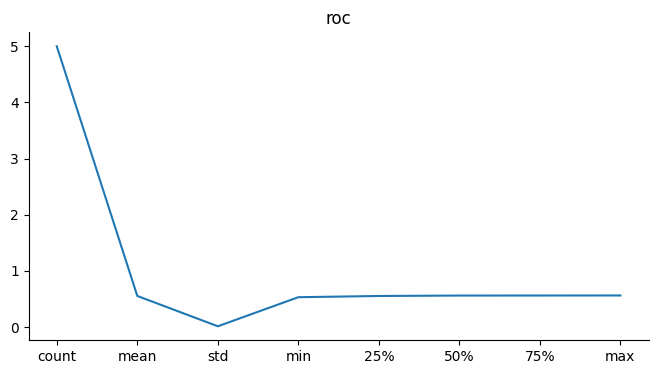

In [99]:
from matplotlib import pyplot as plt
_df_7['roc'].plot(kind='line', figsize=(8, 4), title='roc')
plt.gca().spines[['top', 'right']].set_visible(False)

In [97]:
# train, test = train_test_split(data, test_size=0.2)

# train_model_input = {name:train[name].values for name in feature_names}
# test_model_input = {name:test[name].values for name in feature_names}


# model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
# model.compile("adam", "binary_crossentropy",
#               metrics=['binary_crossentropy'], )

# history = model.fit(train_model_input, train[target].values,
#                     batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
# pred_ans = model.predict(test_model_input, batch_size=256)

In [98]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Step 1: Make a simple dataset
# # This is a simple linear function: y = 2x + 1
# x_train = np.linspace(-10, 10, 100)
# y_train = 2 * x_train + 1

# # Reshape the input to match the input shape of a keras model
# x_train = np.expand_dims(x_train, axis=1)

# # Step 2: Make the model
# model = Sequential()
# model.add(Dense(units=1, input_shape=(1,), activation='linear'))

# # Step 3: Train the model
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(x_train, y_train, epochs=100, batch_size=256)

# # Step 4: Make a test dataset
# x_test = np.linspace(-15, 15, 100)
# x_test = np.expand_dims(x_test, axis=1)

# # Step 5: Use the trained model to make predictions
# pred_y = model.predict(x_test, batch_size=256)

# print("Predicted Y values:")
# print(pred_y)